In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from nltk import ngrams
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset

class ImdbDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list_class, target_list_ratings,file_name_list,MAX_SENTENCE_LENGTH):
        
        self.data_list = data_list
        self.file_name_list = file_name_list
        self.target_list_class = target_list_class
        self.target_list_ratings = target_list_ratings
        assert (len(self.data_list) == len(self.target_list_class))
        self.MAX_SENTENCE_LENGTH = MAX_SENTENCE_LENGTH

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:self.MAX_SENTENCE_LENGTH]
        label = self.target_list_class[key]
        rating = self.target_list_ratings[key]
        names = self.file_name_list[key]
        return [token_idx, len(token_idx), int(label),int(rating),names]

In [34]:
def imdb_collate_func(batch, MAX_SENTENCE_LENGTH = 100):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    rating_list = []
    names_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
        rating_list.append(datum[-2])
        names_list.append(datum[-1])
        
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)).type(torch.LongTensor), torch.LongTensor(length_list), \
            torch.LongTensor(label_list),torch.FloatTensor(rating_list), np.array(names_list)]

In [5]:
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

In [6]:
def token2index_dataset(tokens_data, token2id):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,50)
        self.linear3 = nn.Linear(50,2)
#         self.linear2 = nn.Linear(emb_dim,1)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out_1 = self.linear(out.float())
        out_1 = self.linear3(out_1)
#         out_2 = self.linear2(out.float()).squeeze()
        return out_1

# emb_dim = 300
# model = BagOfWords(len(id2token), emb_dim)

In [82]:
def test_model(loader, model, criterion):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    incorrect_fp_list = []
    incorrect_fn_list = []
    predictions = []
    for data, lengths, labels,label_rat,names in loader:
        data_batch, length_batch, label_batch, label_rat_batch = data, lengths, labels, label_rat
        out = model(data_batch, length_batch)
        outputs = F.softmax(out, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs,label_batch)
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        mask_fn = (predicted.squeeze() == 0)*(label_batch.squeeze() == 1)
        mask_fp = (predicted.squeeze() == 1)*(label_batch.squeeze() == 0)
        predictions.append((names,predicted.squeeze().numpy(),label_batch.numpy()))
        try:
            incorrect_fp_list.append(names[mask_fp])
        except:
            pass
        try:
            incorrect_fn_list.append(names[mask_fn])
        except:
            pass
#         loss = criterion2(torch.round(out[1]),label_rat_batch).item()
    return (100 * correct / total), loss.item(), incorrect_fp_list, incorrect_fn_list, predictions

In [9]:
def train_model(max_vocab_size,emb_dim,opt,name,MAX_SENTENCE_LENGTH = 300, annealing = False,\
                num_epochs = 5,learning_rate = 0.01, test = False):
    
    token2id, id2token = build_vocab(all_tokens,max_vocab_size)

    train_data_indices = token2index_dataset(train_data_tokens,token2id)
    val_data_indices = token2index_dataset(val_data_tokens,token2id)
    test_data_indices = token2index_dataset(test_data_tokens,token2id)
    BATCH_SIZE = 32
    train_dataset = ImdbDataset(train_data_indices, train_labels, train_ratings,train_files, MAX_SENTENCE_LENGTH)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    val_dataset = ImdbDataset(val_data_indices, val_labels, val_ratings, val_files,MAX_SENTENCE_LENGTH)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    test_dataset = ImdbDataset(test_data_indices, test_labels, test_ratings, test_files,MAX_SENTENCE_LENGTH)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)
    model = BagOfWords(len(id2token), emb_dim)

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    # criterion2 = torch.nn.MSELoss()
    if opt == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_dict = {'train':[],'val':[]}
    acc_dict = {'train':[],'val':[]}
    best_acc = 0
    incorrect_dict = {'fp':[],'fn':[]}
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        if annealing:
            optimizer.defaults['lr'] = learning_rate/(epoch+1)
        for i, (data, lengths, labels,label_rat,_) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch, label_rat_batch = data, lengths, labels, label_rat
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            out = F.softmax(outputs, dim=1)
            if i>0 and i%100 == 0:
                predicted = out.max(1, keepdim=True)[1]
                total += labels.size(0)
                correct += predicted.eq(labels.view_as(predicted)).sum().item()
                loss_dict['train'].append(loss.item()/total)
                acc_dict['train'].append((100 * correct / total))
    #         loss_2 = criterion2(torch.round(outputs[1]), label_rat_batch)
    #         loss = loss_2
            # validate every 100 iterations
            if i>0 and i%100 == 0:
                # validate
                val_acc, val_loss,fp_list, fn_list= test_model(val_loader, model, criterion)
                loss_dict['val'].append(val_loss)
                acc_dict['val'].append(val_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                                   epoch+1, num_epochs, i+1, len(train_loader), val_acc))
                if val_acc > best_acc:
                    torch.save(model,name)
                    incorrect_dict['fp'] = fp_list
                    incorrect_dict['fn'] = fn_list
                    best_acc = val_acc
                    best_wts = model.state_dict()
    print('Best Accuracy:{}'.format(best_acc))
    pickling(loss_dict,name+'_loss_hist')
    pickling(acc_dict,name+'_acc_hist')
    pickling(incorrect_dict,name+'_incorrect_preds')
    model.load_state_dict(best_wts)
    return model, loss_dict, acc_dict, incorrect_dict

# 1. Experiment with tokenizer:
Three tokens are experimented:
1. No pre-processing of the tokens
2. Pre-processing with lower casing the tokens and removing the punctuations
3. Pre-processing with lower casing the tokens and removing the punctuations and stop words

Other hyper-parameters are kept constant: unigram, Max_sentence_length = 300, Max_vocab = 50k, emb_dim = 200, opitm = Adam, constant lr = 1e-3.

## 1. No pre-processing of the tokens

In [49]:
val_data_tokens = unpickling('val_data_tokens_no_preprocessing_n=1.p')
test_data_tokens = unpickling('test_data_tokens_no_preprocessing_n=1.p')
train_data_tokens = unpickling('train_data_tokens_no_preprocessing_n=1.p')
all_tokens = unpickling('all_train_tokens_no_preprocessing_n=1.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [51]:
model, loss_dict, acc_dict, incorrect_dict = train_model(50000,200,'Adam','unigram_50k_200_ad_no_preprocessing_const'\
                                                         , num_epochs = 5)

Epoch: [1/5], Step: [101/625], Validation Acc: 82.08


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/625], Validation Acc: 84.5
Epoch: [1/5], Step: [301/625], Validation Acc: 84.96
Epoch: [1/5], Step: [401/625], Validation Acc: 86.72
Epoch: [1/5], Step: [501/625], Validation Acc: 86.04
Epoch: [1/5], Step: [601/625], Validation Acc: 87.24
Epoch: [2/5], Step: [101/625], Validation Acc: 87.38
Epoch: [2/5], Step: [201/625], Validation Acc: 87.18
Epoch: [2/5], Step: [301/625], Validation Acc: 86.64
Epoch: [2/5], Step: [401/625], Validation Acc: 86.52
Epoch: [2/5], Step: [501/625], Validation Acc: 86.9
Epoch: [2/5], Step: [601/625], Validation Acc: 87.14
Epoch: [3/5], Step: [101/625], Validation Acc: 86.76
Epoch: [3/5], Step: [201/625], Validation Acc: 86.26
Epoch: [3/5], Step: [301/625], Validation Acc: 86.18
Epoch: [3/5], Step: [401/625], Validation Acc: 86.56
Epoch: [3/5], Step: [501/625], Validation Acc: 84.1
Epoch: [3/5], Step: [601/625], Validation Acc: 85.76
Epoch: [4/5], Step: [101/625], Validation Acc: 86.04
Epoch: [4/5], Step: [201/625], Validation Acc: 85

## Loss Curve

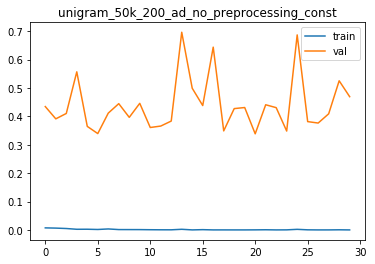

In [55]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('unigram_50k_200_ad_no_preprocessing_const')
plt.show()

## Accuracy Curve

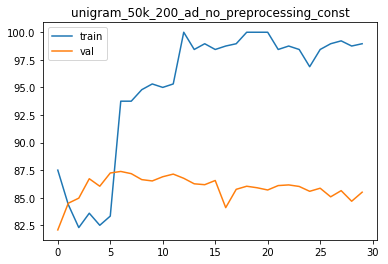

In [56]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('unigram_50k_200_ad_no_preprocessing_const')
plt.show()

## 2. Pre-processing with lower casing the tokens and removing the punctuations

In [57]:
val_data_tokens = unpickling('val_data_tokens_n=1.p')
test_data_tokens = unpickling('test_data_tokens_n=1.p')
train_data_tokens = unpickling('train_data_tokens_n=1.p')
all_tokens = unpickling('all_train_tokens_n=1.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [58]:
model, loss_dict, acc_dict, incorrect_dict = train_model(50000,200,'Adam','unigram_50k_200_ad_preprocessing_const'\
                                                         , num_epochs = 5)

Epoch: [1/5], Step: [101/625], Validation Acc: 81.58


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/625], Validation Acc: 84.28
Epoch: [1/5], Step: [301/625], Validation Acc: 86.46
Epoch: [1/5], Step: [401/625], Validation Acc: 86.68
Epoch: [1/5], Step: [501/625], Validation Acc: 87.6
Epoch: [1/5], Step: [601/625], Validation Acc: 87.22
Epoch: [2/5], Step: [101/625], Validation Acc: 87.16
Epoch: [2/5], Step: [201/625], Validation Acc: 87.86
Epoch: [2/5], Step: [301/625], Validation Acc: 86.66
Epoch: [2/5], Step: [401/625], Validation Acc: 87.02
Epoch: [2/5], Step: [501/625], Validation Acc: 87.46
Epoch: [2/5], Step: [601/625], Validation Acc: 87.32
Epoch: [3/5], Step: [101/625], Validation Acc: 86.96
Epoch: [3/5], Step: [201/625], Validation Acc: 85.72
Epoch: [3/5], Step: [301/625], Validation Acc: 87.08
Epoch: [3/5], Step: [401/625], Validation Acc: 86.94
Epoch: [3/5], Step: [501/625], Validation Acc: 86.64
Epoch: [3/5], Step: [601/625], Validation Acc: 85.64
Epoch: [4/5], Step: [101/625], Validation Acc: 86.06
Epoch: [4/5], Step: [201/625], Validation Acc: 

## Loss Curve

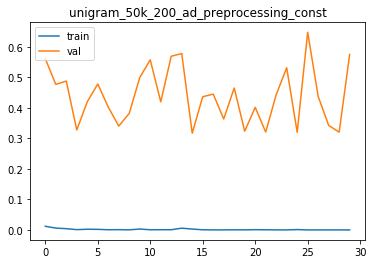

In [59]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('unigram_50k_200_ad_preprocessing_const')
plt.show()

## Accuracy Curve

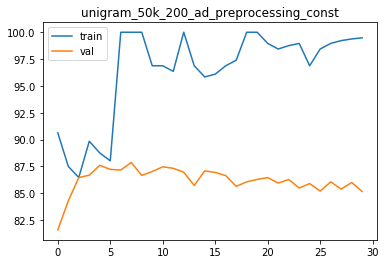

In [60]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('unigram_50k_200_ad_preprocessing_const')
plt.show()

## 3. Pre-processing with lower casing the tokens and removing the punctuations and stop words

In [61]:
val_data_tokens = unpickling('val_data_tokens_wo_stop_words_n=1.p')
test_data_tokens = unpickling('test_data_wo_stop_tokens_n=1.p')
train_data_tokens = unpickling('train_data_wo_stop_tokens_n=1.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=1.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [62]:
model, loss_dict, acc_dict, incorrect_dict = train_model(50000,200,'Adam','unigram_50k_200_ad_wo_stop_words_const'\
                                                         , num_epochs = 5)

Epoch: [1/5], Step: [101/625], Validation Acc: 83.78


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/625], Validation Acc: 85.5
Epoch: [1/5], Step: [301/625], Validation Acc: 86.8
Epoch: [1/5], Step: [401/625], Validation Acc: 86.92
Epoch: [1/5], Step: [501/625], Validation Acc: 87.42
Epoch: [1/5], Step: [601/625], Validation Acc: 87.92
Epoch: [2/5], Step: [101/625], Validation Acc: 87.74
Epoch: [2/5], Step: [201/625], Validation Acc: 87.28
Epoch: [2/5], Step: [301/625], Validation Acc: 88.02
Epoch: [2/5], Step: [401/625], Validation Acc: 86.86
Epoch: [2/5], Step: [501/625], Validation Acc: 86.62
Epoch: [2/5], Step: [601/625], Validation Acc: 87.68
Epoch: [3/5], Step: [101/625], Validation Acc: 87.24
Epoch: [3/5], Step: [201/625], Validation Acc: 86.98
Epoch: [3/5], Step: [301/625], Validation Acc: 86.98
Epoch: [3/5], Step: [401/625], Validation Acc: 86.74
Epoch: [3/5], Step: [501/625], Validation Acc: 86.32
Epoch: [3/5], Step: [601/625], Validation Acc: 86.2
Epoch: [4/5], Step: [101/625], Validation Acc: 86.3
Epoch: [4/5], Step: [201/625], Validation Acc: 86.

## Loss Curve

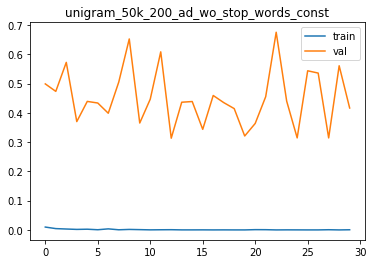

In [63]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('unigram_50k_200_ad_wo_stop_words_const')
plt.show()

## Accuracy Curve

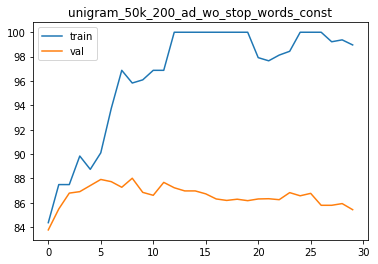

In [64]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('unigram_50k_200_ad_wo_stop_words_const')
plt.show()

## Conclusion:
Based on the above experiments, it was seen that tokenizer where stop words were removed works the best with best validation accuracy of 88.02%.

# 2. Experiment with the n-grams:
For the best tokenizer obtained from above, we will experiment with n-grams: 1-gram, upto 2-grams, upto 3-grams, upto 4-grams.
Other hyper-parameters are kept constant: tokenizer = w/o stop words, Max_sentence_length = 300, Max_vocab = 100k, emb_dim = 200, opitm = Adam, constant lr = 1e-3.

## 1-gram

In [65]:
val_data_tokens = unpickling('val_data_tokens_wo_stop_words_n=1.p')
test_data_tokens = unpickling('test_data_wo_stop_tokens_n=1.p')
train_data_tokens = unpickling('train_data_wo_stop_tokens_n=1.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=1.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [66]:
model, loss_dict, acc_dict, incorrect_dict = train_model(100000,200,'Adam','unigram_100k_200_ad_wo_stop_words_const'\
                                                         , num_epochs = 5)

Epoch: [1/5], Step: [101/625], Validation Acc: 82.76


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/625], Validation Acc: 85.94
Epoch: [1/5], Step: [301/625], Validation Acc: 86.74
Epoch: [1/5], Step: [401/625], Validation Acc: 87.66
Epoch: [1/5], Step: [501/625], Validation Acc: 87.88
Epoch: [1/5], Step: [601/625], Validation Acc: 87.48
Epoch: [2/5], Step: [101/625], Validation Acc: 87.6
Epoch: [2/5], Step: [201/625], Validation Acc: 87.64
Epoch: [2/5], Step: [301/625], Validation Acc: 86.76
Epoch: [2/5], Step: [401/625], Validation Acc: 87.3
Epoch: [2/5], Step: [501/625], Validation Acc: 87.26
Epoch: [2/5], Step: [601/625], Validation Acc: 87.26
Epoch: [3/5], Step: [101/625], Validation Acc: 87.04
Epoch: [3/5], Step: [201/625], Validation Acc: 86.96
Epoch: [3/5], Step: [301/625], Validation Acc: 86.44
Epoch: [3/5], Step: [401/625], Validation Acc: 86.88
Epoch: [3/5], Step: [501/625], Validation Acc: 86.48
Epoch: [3/5], Step: [601/625], Validation Acc: 87.26
Epoch: [4/5], Step: [101/625], Validation Acc: 86.34
Epoch: [4/5], Step: [201/625], Validation Acc: 8

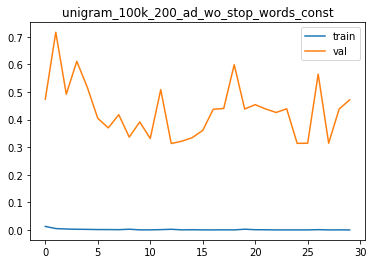

In [67]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('unigram_100k_200_ad_wo_stop_words_const')
plt.show()

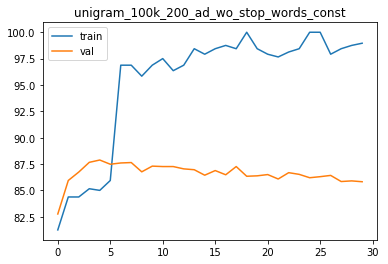

In [68]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('unigram_100k_200_ad_wo_stop_words_const')
plt.show()

## upto 2-grams

In [69]:
val_data_tokens = unpickling('val_data_tokens_wo_stop_words_n=2.p')
test_data_tokens = unpickling('test_data_wo_stop_tokens_n=2.p')
train_data_tokens = unpickling('train_data_wo_stop_tokens_n=2.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=2.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [70]:
model, loss_dict, acc_dict, incorrect_dict = train_model(100000,200,'Adam','bigram_100k_200_ad_wo_stop_words_const'\
                                                         , num_epochs = 5)

Epoch: [1/5], Step: [101/625], Validation Acc: 83.9


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/625], Validation Acc: 86.4
Epoch: [1/5], Step: [301/625], Validation Acc: 87.06
Epoch: [1/5], Step: [401/625], Validation Acc: 88.4
Epoch: [1/5], Step: [501/625], Validation Acc: 88.5
Epoch: [1/5], Step: [601/625], Validation Acc: 89.54
Epoch: [2/5], Step: [101/625], Validation Acc: 88.72
Epoch: [2/5], Step: [201/625], Validation Acc: 88.94
Epoch: [2/5], Step: [301/625], Validation Acc: 88.56
Epoch: [2/5], Step: [401/625], Validation Acc: 86.94
Epoch: [2/5], Step: [501/625], Validation Acc: 88.56
Epoch: [2/5], Step: [601/625], Validation Acc: 88.28
Epoch: [3/5], Step: [101/625], Validation Acc: 88.26
Epoch: [3/5], Step: [201/625], Validation Acc: 87.66
Epoch: [3/5], Step: [301/625], Validation Acc: 88.02
Epoch: [3/5], Step: [401/625], Validation Acc: 87.84
Epoch: [3/5], Step: [501/625], Validation Acc: 88.14
Epoch: [3/5], Step: [601/625], Validation Acc: 87.86
Epoch: [4/5], Step: [101/625], Validation Acc: 86.4
Epoch: [4/5], Step: [201/625], Validation Acc: 87.

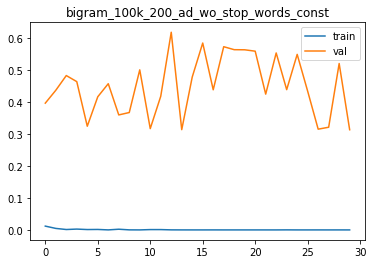

In [71]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_200_ad_wo_stop_words_const')
plt.show()

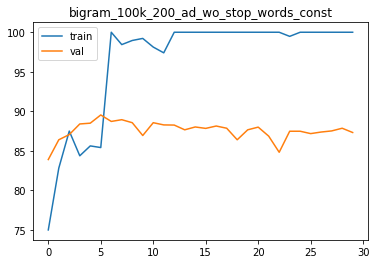

In [72]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_200_ad_wo_stop_words_const')
plt.show()

## upto 3-grams

In [73]:
val_data_tokens = unpickling('val_data_tokens_wo_stop_words_n=3.p')
test_data_tokens = unpickling('test_data_wo_stop_tokens_n=3.p')
train_data_tokens = unpickling('train_data_wo_stop_tokens_n=3.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=3.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [74]:
model, loss_dict, acc_dict, incorrect_dict = train_model(100000,200,'Adam','trigram_100k_200_ad_wo_stop_words_const'\
                                                         , num_epochs = 5)

Epoch: [1/5], Step: [101/625], Validation Acc: 71.98


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/625], Validation Acc: 83.9
Epoch: [1/5], Step: [301/625], Validation Acc: 80.72
Epoch: [1/5], Step: [401/625], Validation Acc: 88.5
Epoch: [1/5], Step: [501/625], Validation Acc: 88.5
Epoch: [1/5], Step: [601/625], Validation Acc: 89.22
Epoch: [2/5], Step: [101/625], Validation Acc: 89.36
Epoch: [2/5], Step: [201/625], Validation Acc: 89.12
Epoch: [2/5], Step: [301/625], Validation Acc: 88.68
Epoch: [2/5], Step: [401/625], Validation Acc: 86.7
Epoch: [2/5], Step: [501/625], Validation Acc: 88.68
Epoch: [2/5], Step: [601/625], Validation Acc: 86.48
Epoch: [3/5], Step: [101/625], Validation Acc: 88.26
Epoch: [3/5], Step: [201/625], Validation Acc: 88.36
Epoch: [3/5], Step: [301/625], Validation Acc: 87.52
Epoch: [3/5], Step: [401/625], Validation Acc: 88.38
Epoch: [3/5], Step: [501/625], Validation Acc: 88.34
Epoch: [3/5], Step: [601/625], Validation Acc: 88.26
Epoch: [4/5], Step: [101/625], Validation Acc: 88.34
Epoch: [4/5], Step: [201/625], Validation Acc: 88.

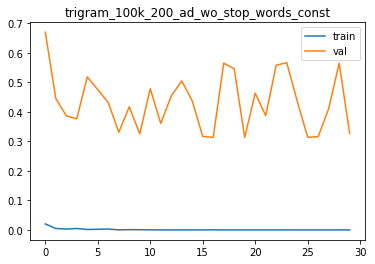

In [75]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('trigram_100k_200_ad_wo_stop_words_const')
plt.show()

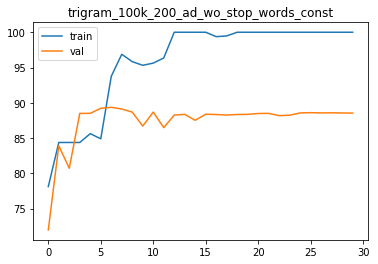

In [76]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('trigram_100k_200_ad_wo_stop_words_const')
plt.show()

## upto 4-grams

In [10]:
val_data_tokens = unpickling('val_data_tokens_wo_stop_words_n=4.p')
test_data_tokens = unpickling('test_data_wo_stop_tokens_n=4.p')
train_data_tokens = unpickling('train_data_wo_stop_tokens_n=4.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=4.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [11]:
model, loss_dict, acc_dict, incorrect_dict = train_model(100000,200,'Adam','quatgram_100k_200_ad_wo_stop_words_const'\
                                                         , num_epochs = 5)

Epoch: [1/5], Step: [101/625], Validation Acc: 54.44


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/625], Validation Acc: 85.86
Epoch: [1/5], Step: [301/625], Validation Acc: 87.68
Epoch: [1/5], Step: [401/625], Validation Acc: 88.46
Epoch: [1/5], Step: [501/625], Validation Acc: 88.82
Epoch: [1/5], Step: [601/625], Validation Acc: 88.48
Epoch: [2/5], Step: [101/625], Validation Acc: 88.76
Epoch: [2/5], Step: [201/625], Validation Acc: 88.52
Epoch: [2/5], Step: [301/625], Validation Acc: 86.32
Epoch: [2/5], Step: [401/625], Validation Acc: 88.72
Epoch: [2/5], Step: [501/625], Validation Acc: 88.98
Epoch: [2/5], Step: [601/625], Validation Acc: 88.6
Epoch: [3/5], Step: [101/625], Validation Acc: 88.96
Epoch: [3/5], Step: [201/625], Validation Acc: 88.2
Epoch: [3/5], Step: [301/625], Validation Acc: 88.96
Epoch: [3/5], Step: [401/625], Validation Acc: 88.76
Epoch: [3/5], Step: [501/625], Validation Acc: 87.68
Epoch: [3/5], Step: [601/625], Validation Acc: 88.3
Epoch: [4/5], Step: [101/625], Validation Acc: 88.54
Epoch: [4/5], Step: [201/625], Validation Acc: 88

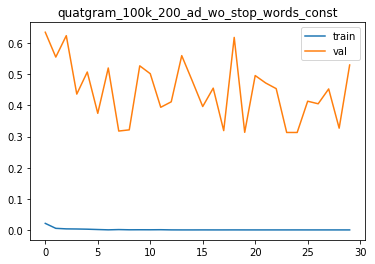

In [12]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('quatgram_100k_200_ad_wo_stop_words_const')
plt.show()

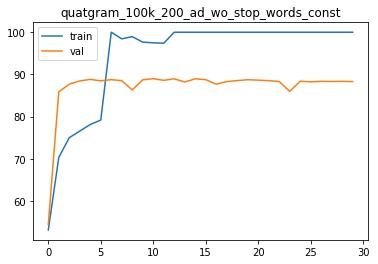

In [13]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('quatgram_100k_200_ad_wo_stop_words_const')
plt.show()

## Conclusion
Based on the experiments performed above, best validation accuracy was obtained for 2-gram model

# 3. Experiment with max_vocab
For the best tokenizer and n-gram obtained from above, we will experiment with max_vocab: [10k,50k,100k,200k].
Other hyper-parameters are kept constant: tokenizer = w/o stop words, Max_sentence_length = 300,n-gram = upto 2, emb_dim = 200, opitm = Adam, constant lr = 1e-3.

## A. Max_vocab = 10k

In [14]:
val_data_tokens = unpickling('val_data_tokens_wo_stop_words_n=2.p')
test_data_tokens = unpickling('test_data_wo_stop_tokens_n=2.p')
train_data_tokens = unpickling('train_data_wo_stop_tokens_n=2.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=2.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [15]:
model, loss_dict, acc_dict, incorrect_dict = train_model(10000,200,'Adam','bigram_10k_200_ad_wo_stop_words_const'\
                                                         , num_epochs = 5)

Epoch: [1/5], Step: [101/625], Validation Acc: 80.42


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/625], Validation Acc: 85.7
Epoch: [1/5], Step: [301/625], Validation Acc: 87.3
Epoch: [1/5], Step: [401/625], Validation Acc: 86.76
Epoch: [1/5], Step: [501/625], Validation Acc: 86.86
Epoch: [1/5], Step: [601/625], Validation Acc: 85.38
Epoch: [2/5], Step: [101/625], Validation Acc: 87.94
Epoch: [2/5], Step: [201/625], Validation Acc: 88.08
Epoch: [2/5], Step: [301/625], Validation Acc: 87.46
Epoch: [2/5], Step: [401/625], Validation Acc: 88.0
Epoch: [2/5], Step: [501/625], Validation Acc: 87.9
Epoch: [2/5], Step: [601/625], Validation Acc: 87.88
Epoch: [3/5], Step: [101/625], Validation Acc: 87.86
Epoch: [3/5], Step: [201/625], Validation Acc: 87.18
Epoch: [3/5], Step: [301/625], Validation Acc: 87.1
Epoch: [3/5], Step: [401/625], Validation Acc: 86.44
Epoch: [3/5], Step: [501/625], Validation Acc: 87.1
Epoch: [3/5], Step: [601/625], Validation Acc: 87.52
Epoch: [4/5], Step: [101/625], Validation Acc: 87.4
Epoch: [4/5], Step: [201/625], Validation Acc: 87.06


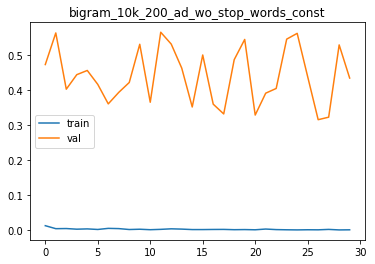

In [16]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_10k_200_ad_wo_stop_words_const')
plt.show()

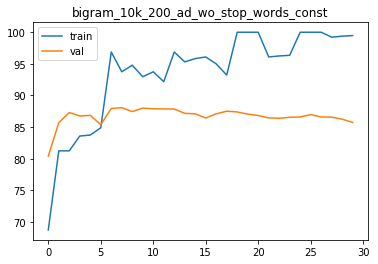

In [17]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_10k_200_ad_wo_stop_words_const')
plt.show()

## B. Max_vocab = 50k

In [18]:
val_data_tokens = unpickling('val_data_tokens_wo_stop_words_n=2.p')
test_data_tokens = unpickling('test_data_wo_stop_tokens_n=2.p')
train_data_tokens = unpickling('train_data_wo_stop_tokens_n=2.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=2.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [19]:
model, loss_dict, acc_dict, incorrect_dict = train_model(50000,200,'Adam','bigram_50k_200_ad_wo_stop_words_const'\
                                                         , num_epochs = 5)

Epoch: [1/5], Step: [101/625], Validation Acc: 81.64


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/625], Validation Acc: 86.46
Epoch: [1/5], Step: [301/625], Validation Acc: 87.02
Epoch: [1/5], Step: [401/625], Validation Acc: 88.02
Epoch: [1/5], Step: [501/625], Validation Acc: 88.78
Epoch: [1/5], Step: [601/625], Validation Acc: 88.68
Epoch: [2/5], Step: [101/625], Validation Acc: 89.14
Epoch: [2/5], Step: [201/625], Validation Acc: 88.72
Epoch: [2/5], Step: [301/625], Validation Acc: 89.0
Epoch: [2/5], Step: [401/625], Validation Acc: 88.18
Epoch: [2/5], Step: [501/625], Validation Acc: 85.96
Epoch: [2/5], Step: [601/625], Validation Acc: 87.94
Epoch: [3/5], Step: [101/625], Validation Acc: 88.22
Epoch: [3/5], Step: [201/625], Validation Acc: 87.76
Epoch: [3/5], Step: [301/625], Validation Acc: 87.64
Epoch: [3/5], Step: [401/625], Validation Acc: 86.9
Epoch: [3/5], Step: [501/625], Validation Acc: 87.66
Epoch: [3/5], Step: [601/625], Validation Acc: 87.44
Epoch: [4/5], Step: [101/625], Validation Acc: 87.4
Epoch: [4/5], Step: [201/625], Validation Acc: 87

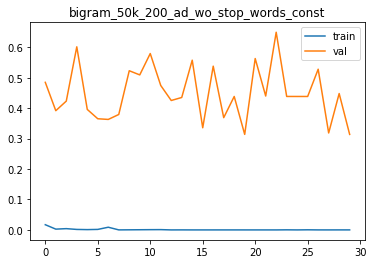

In [20]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_50k_200_ad_wo_stop_words_const')
plt.show()

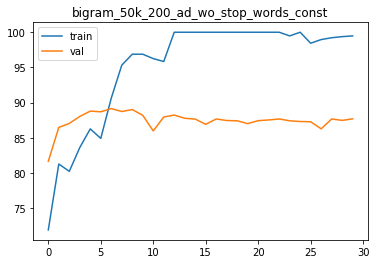

In [21]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_50k_200_ad_wo_stop_words_const')
plt.show()

## C. Max_vocab = 100k

In [22]:
val_data_tokens = unpickling('val_data_tokens_wo_stop_words_n=2.p')
test_data_tokens = unpickling('test_data_wo_stop_tokens_n=2.p')
train_data_tokens = unpickling('train_data_wo_stop_tokens_n=2.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=2.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [23]:
model, loss_dict, acc_dict, incorrect_dict = train_model(100000,200,'Adam','bigram_100k_200_ad_wo_stop_words_const'\
                                                         , num_epochs = 5)

Epoch: [1/5], Step: [101/625], Validation Acc: 83.34


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/625], Validation Acc: 87.12
Epoch: [1/5], Step: [301/625], Validation Acc: 86.42
Epoch: [1/5], Step: [401/625], Validation Acc: 87.96
Epoch: [1/5], Step: [501/625], Validation Acc: 88.78
Epoch: [1/5], Step: [601/625], Validation Acc: 87.68
Epoch: [2/5], Step: [101/625], Validation Acc: 89.44
Epoch: [2/5], Step: [201/625], Validation Acc: 89.4
Epoch: [2/5], Step: [301/625], Validation Acc: 88.62
Epoch: [2/5], Step: [401/625], Validation Acc: 88.38
Epoch: [2/5], Step: [501/625], Validation Acc: 87.94
Epoch: [2/5], Step: [601/625], Validation Acc: 88.02
Epoch: [3/5], Step: [101/625], Validation Acc: 88.3
Epoch: [3/5], Step: [201/625], Validation Acc: 88.16
Epoch: [3/5], Step: [301/625], Validation Acc: 87.98
Epoch: [3/5], Step: [401/625], Validation Acc: 88.22
Epoch: [3/5], Step: [501/625], Validation Acc: 88.26
Epoch: [3/5], Step: [601/625], Validation Acc: 87.22
Epoch: [4/5], Step: [101/625], Validation Acc: 87.88
Epoch: [4/5], Step: [201/625], Validation Acc: 8

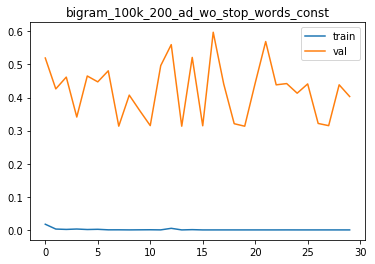

In [24]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_200_ad_wo_stop_words_const')
plt.show()

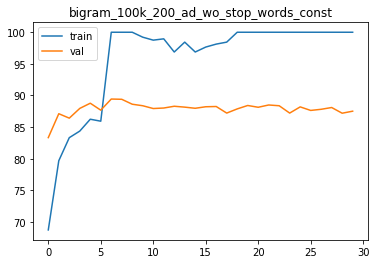

In [25]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_200_ad_wo_stop_words_const')
plt.show()

## D. Max_vocab = 200k

In [26]:
val_data_tokens = unpickling('val_data_tokens_wo_stop_words_n=2.p')
test_data_tokens = unpickling('test_data_wo_stop_tokens_n=2.p')
train_data_tokens = unpickling('train_data_wo_stop_tokens_n=2.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=2.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [27]:
model, loss_dict, acc_dict, incorrect_dict = train_model(200000,200,'Adam','bigram_200k_200_ad_wo_stop_words_const'\
                                                         , num_epochs = 5)

Epoch: [1/5], Step: [101/625], Validation Acc: 77.86


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/625], Validation Acc: 86.48
Epoch: [1/5], Step: [301/625], Validation Acc: 87.66
Epoch: [1/5], Step: [401/625], Validation Acc: 88.54
Epoch: [1/5], Step: [501/625], Validation Acc: 88.2
Epoch: [1/5], Step: [601/625], Validation Acc: 89.12
Epoch: [2/5], Step: [101/625], Validation Acc: 89.06
Epoch: [2/5], Step: [201/625], Validation Acc: 88.88
Epoch: [2/5], Step: [301/625], Validation Acc: 87.2
Epoch: [2/5], Step: [401/625], Validation Acc: 89.24
Epoch: [2/5], Step: [501/625], Validation Acc: 88.82
Epoch: [2/5], Step: [601/625], Validation Acc: 88.52
Epoch: [3/5], Step: [101/625], Validation Acc: 88.7
Epoch: [3/5], Step: [201/625], Validation Acc: 88.72
Epoch: [3/5], Step: [301/625], Validation Acc: 88.66
Epoch: [3/5], Step: [401/625], Validation Acc: 88.68
Epoch: [3/5], Step: [501/625], Validation Acc: 88.48
Epoch: [3/5], Step: [601/625], Validation Acc: 88.1
Epoch: [4/5], Step: [101/625], Validation Acc: 88.5
Epoch: [4/5], Step: [201/625], Validation Acc: 88.5

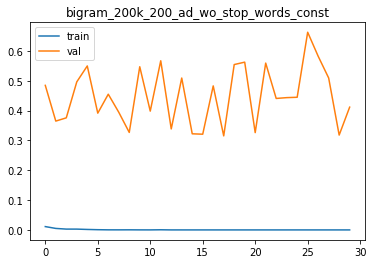

In [28]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_200k_200_ad_wo_stop_words_const')
plt.show()

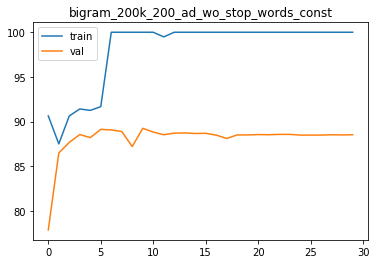

In [29]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_200k_200_ad_wo_stop_words_const')
plt.show()

## Conclusion
Based on the above experiments, best validation accuracy was obtained for max_vocab = 100k

# 4. Experiment with embedding dimensions
For the best tokenizer, n-gram and vocab size obtained from above, we will experiment with embedding dimension: [50,100,200,300].
Other hyper-parameters are kept constant: tokenizer = w/o stop words, Max_sentence_length = 300,n-gram = upto 2, max_vocab_size = 100k, opitm = Adam, constant lr = 1e-3.

## Embedding dim = 50

In [30]:
val_data_tokens = unpickling('val_data_tokens_wo_stop_words_n=2.p')
test_data_tokens = unpickling('test_data_wo_stop_tokens_n=2.p')
train_data_tokens = unpickling('train_data_wo_stop_tokens_n=2.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=2.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [31]:
model, loss_dict, acc_dict, incorrect_dict = train_model(100000,50,'Adam','bigram_100k_50_ad_wo_stop_words_const'\
                                                         , num_epochs = 5)

Epoch: [1/5], Step: [101/625], Validation Acc: 83.68


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/625], Validation Acc: 86.0
Epoch: [1/5], Step: [301/625], Validation Acc: 86.7
Epoch: [1/5], Step: [401/625], Validation Acc: 86.48
Epoch: [1/5], Step: [501/625], Validation Acc: 88.26
Epoch: [1/5], Step: [601/625], Validation Acc: 88.8
Epoch: [2/5], Step: [101/625], Validation Acc: 88.9
Epoch: [2/5], Step: [201/625], Validation Acc: 89.02
Epoch: [2/5], Step: [301/625], Validation Acc: 88.54
Epoch: [2/5], Step: [401/625], Validation Acc: 88.18
Epoch: [2/5], Step: [501/625], Validation Acc: 88.16
Epoch: [2/5], Step: [601/625], Validation Acc: 87.2
Epoch: [3/5], Step: [101/625], Validation Acc: 87.94
Epoch: [3/5], Step: [201/625], Validation Acc: 87.82
Epoch: [3/5], Step: [301/625], Validation Acc: 87.74
Epoch: [3/5], Step: [401/625], Validation Acc: 87.84
Epoch: [3/5], Step: [501/625], Validation Acc: 87.84
Epoch: [3/5], Step: [601/625], Validation Acc: 88.12
Epoch: [4/5], Step: [101/625], Validation Acc: 87.94
Epoch: [4/5], Step: [201/625], Validation Acc: 87.9

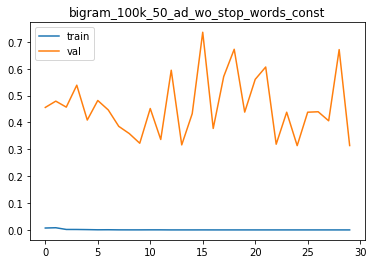

In [32]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_50_ad_wo_stop_words_const')
plt.show()

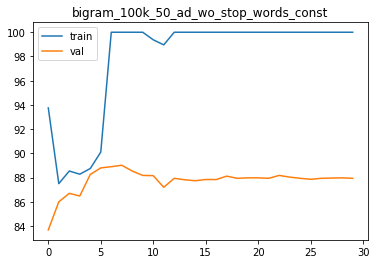

In [33]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_50_ad_wo_stop_words_const')
plt.show()

## Embedding dim = 100

In [34]:
val_data_tokens = unpickling('val_data_tokens_wo_stop_words_n=2.p')
test_data_tokens = unpickling('test_data_wo_stop_tokens_n=2.p')
train_data_tokens = unpickling('train_data_wo_stop_tokens_n=2.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=2.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [35]:
model, loss_dict, acc_dict, incorrect_dict = train_model(100000,100,'Adam','bigram_100k_100_ad_wo_stop_words_const'\
                                                         , num_epochs = 5)

Epoch: [1/5], Step: [101/625], Validation Acc: 82.12


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/625], Validation Acc: 84.8
Epoch: [1/5], Step: [301/625], Validation Acc: 87.74
Epoch: [1/5], Step: [401/625], Validation Acc: 87.92
Epoch: [1/5], Step: [501/625], Validation Acc: 89.46
Epoch: [1/5], Step: [601/625], Validation Acc: 88.98
Epoch: [2/5], Step: [101/625], Validation Acc: 89.38
Epoch: [2/5], Step: [201/625], Validation Acc: 88.18
Epoch: [2/5], Step: [301/625], Validation Acc: 87.94
Epoch: [2/5], Step: [401/625], Validation Acc: 88.6
Epoch: [2/5], Step: [501/625], Validation Acc: 88.6
Epoch: [2/5], Step: [601/625], Validation Acc: 88.26
Epoch: [3/5], Step: [101/625], Validation Acc: 88.26
Epoch: [3/5], Step: [201/625], Validation Acc: 88.38
Epoch: [3/5], Step: [301/625], Validation Acc: 87.42
Epoch: [3/5], Step: [401/625], Validation Acc: 88.12
Epoch: [3/5], Step: [501/625], Validation Acc: 87.58
Epoch: [3/5], Step: [601/625], Validation Acc: 87.72
Epoch: [4/5], Step: [101/625], Validation Acc: 87.32
Epoch: [4/5], Step: [201/625], Validation Acc: 87

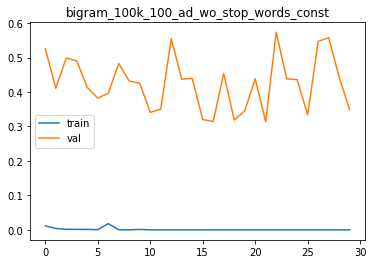

In [36]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_100_ad_wo_stop_words_const')
plt.show()

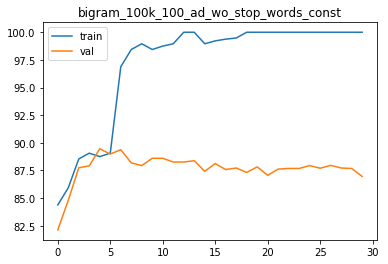

In [37]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_100_ad_wo_stop_words_const')
plt.show()

## Embedding dim = 200

In [10]:
val_data_tokens = unpickling('val_data_tokens_wo_stop_words_n=2.p')
test_data_tokens = unpickling('test_data_wo_stop_tokens_n=2.p')
train_data_tokens = unpickling('train_data_wo_stop_tokens_n=2.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=2.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [11]:
model, loss_dict, acc_dict, incorrect_dict = train_model(100000,200,'Adam','bigram_100k_200_ad_wo_stop_words_const'\
                                                         , num_epochs = 5)

Epoch: [1/5], Step: [101/625], Validation Acc: 82.34


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/625], Validation Acc: 83.02
Epoch: [1/5], Step: [301/625], Validation Acc: 87.88
Epoch: [1/5], Step: [401/625], Validation Acc: 88.38
Epoch: [1/5], Step: [501/625], Validation Acc: 89.22
Epoch: [1/5], Step: [601/625], Validation Acc: 89.32
Epoch: [2/5], Step: [101/625], Validation Acc: 89.38
Epoch: [2/5], Step: [201/625], Validation Acc: 89.5
Epoch: [2/5], Step: [301/625], Validation Acc: 88.52
Epoch: [2/5], Step: [401/625], Validation Acc: 88.54
Epoch: [2/5], Step: [501/625], Validation Acc: 88.14
Epoch: [2/5], Step: [601/625], Validation Acc: 87.92
Epoch: [3/5], Step: [101/625], Validation Acc: 88.28
Epoch: [3/5], Step: [201/625], Validation Acc: 88.0
Epoch: [3/5], Step: [301/625], Validation Acc: 88.3
Epoch: [3/5], Step: [401/625], Validation Acc: 87.88
Epoch: [3/5], Step: [501/625], Validation Acc: 88.1
Epoch: [3/5], Step: [601/625], Validation Acc: 88.02
Epoch: [4/5], Step: [101/625], Validation Acc: 87.82
Epoch: [4/5], Step: [201/625], Validation Acc: 87.

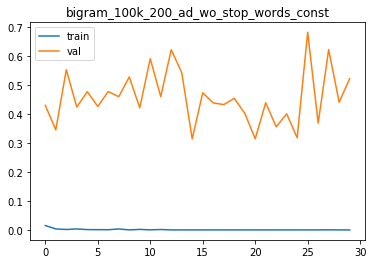

In [12]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_200_ad_wo_stop_words_const')
plt.show()

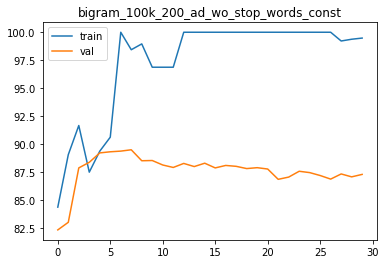

In [13]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_200_ad_wo_stop_words_const')
plt.show()

## Embedding dim = 300

In [14]:
val_data_tokens = unpickling('val_data_tokens_wo_stop_words_n=2.p')
test_data_tokens = unpickling('test_data_wo_stop_tokens_n=2.p')
train_data_tokens = unpickling('train_data_wo_stop_tokens_n=2.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=2.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [15]:
model, loss_dict, acc_dict, incorrect_dict = train_model(100000,300,'Adam','bigram_100k_300_ad_wo_stop_words_const'\
                                                         , num_epochs = 5)

Epoch: [1/5], Step: [101/625], Validation Acc: 76.88


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/625], Validation Acc: 86.9
Epoch: [1/5], Step: [301/625], Validation Acc: 87.68
Epoch: [1/5], Step: [401/625], Validation Acc: 88.94
Epoch: [1/5], Step: [501/625], Validation Acc: 88.9
Epoch: [1/5], Step: [601/625], Validation Acc: 89.7
Epoch: [2/5], Step: [101/625], Validation Acc: 89.52
Epoch: [2/5], Step: [201/625], Validation Acc: 89.08
Epoch: [2/5], Step: [301/625], Validation Acc: 89.08
Epoch: [2/5], Step: [401/625], Validation Acc: 88.82
Epoch: [2/5], Step: [501/625], Validation Acc: 88.64
Epoch: [2/5], Step: [601/625], Validation Acc: 87.12
Epoch: [3/5], Step: [101/625], Validation Acc: 88.22
Epoch: [3/5], Step: [201/625], Validation Acc: 88.74
Epoch: [3/5], Step: [301/625], Validation Acc: 88.72
Epoch: [3/5], Step: [401/625], Validation Acc: 88.26
Epoch: [3/5], Step: [501/625], Validation Acc: 87.92
Epoch: [3/5], Step: [601/625], Validation Acc: 87.42
Epoch: [4/5], Step: [101/625], Validation Acc: 88.1
Epoch: [4/5], Step: [201/625], Validation Acc: 88.

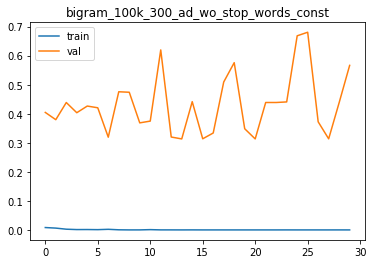

In [16]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_300_ad_wo_stop_words_const')
plt.show()

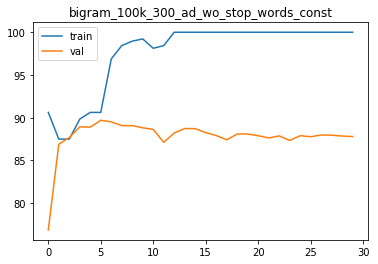

In [17]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_300_ad_wo_stop_words_const')
plt.show()

## Conclusion
Based on the experiments results, the best validation accuracy was obtained for embedding dim = 300

# 5. Optimizer
For the best tokenizer, n-gram, vocab size and Embedding dim obtained from above, we will experiment with optimizer [Adam,SGD].Since, we have already run for Adam, we will only check for the SGD.
Other hyper-parameters are kept constant: tokenizer = w/o stop words, Max_sentence_length = 300,n-gram = upto 2, max_vocab_size = 100k, emb_dim = 300, constant lr = 1e-3.

## SGD

In [18]:
val_data_tokens = unpickling('val_data_tokens_wo_stop_words_n=2.p')
test_data_tokens = unpickling('test_data_wo_stop_tokens_n=2.p')
train_data_tokens = unpickling('train_data_wo_stop_tokens_n=2.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=2.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [27]:
model, loss_dict, acc_dict, incorrect_dict = train_model(100000,300,'SGD','bigram_100k_300_sgd_wo_stop_words_const'\
                                                         , num_epochs =10 )

Epoch: [1/10], Step: [101/625], Validation Acc: 50.48


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/10], Step: [201/625], Validation Acc: 50.5
Epoch: [1/10], Step: [301/625], Validation Acc: 52.68
Epoch: [1/10], Step: [401/625], Validation Acc: 53.26
Epoch: [1/10], Step: [501/625], Validation Acc: 57.12
Epoch: [1/10], Step: [601/625], Validation Acc: 56.24
Epoch: [2/10], Step: [101/625], Validation Acc: 57.62
Epoch: [2/10], Step: [201/625], Validation Acc: 58.24
Epoch: [2/10], Step: [301/625], Validation Acc: 57.86
Epoch: [2/10], Step: [401/625], Validation Acc: 63.0
Epoch: [2/10], Step: [501/625], Validation Acc: 60.0
Epoch: [2/10], Step: [601/625], Validation Acc: 52.94
Epoch: [3/10], Step: [101/625], Validation Acc: 64.1
Epoch: [3/10], Step: [201/625], Validation Acc: 63.82
Epoch: [3/10], Step: [301/625], Validation Acc: 62.46
Epoch: [3/10], Step: [401/625], Validation Acc: 63.24
Epoch: [3/10], Step: [501/625], Validation Acc: 64.62
Epoch: [3/10], Step: [601/625], Validation Acc: 61.44
Epoch: [4/10], Step: [101/625], Validation Acc: 58.34
Epoch: [4/10], Step: [201/625], 

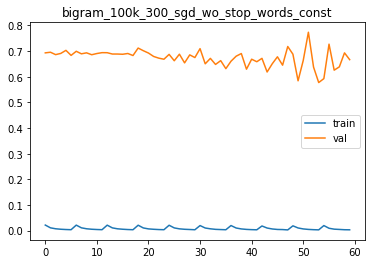

In [28]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_300_sgd_wo_stop_words_const')
plt.show()

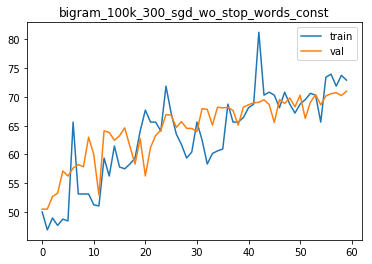

In [29]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_300_sgd_wo_stop_words_const')
plt.show()

## Conclusion
Based on the experiment results, the best validation accuracy was obtained for Adam optimizer.

# 6. Learning Rate Annealing
For the best tokenizer, n-gram, vocab size, Embedding dim and optimizer obtained from above, we will experiment with learning rate annealing [constant,linear annealing].Since, we have already run for constant lr, we will only check for linear annealing.
Other hyper-parameters are kept constant: tokenizer = w/o stop words, Max_sentence_length = 300,n-gram = upto 2, max_vocab_size = 100k, emb_dim = 300, Optimizer = Adam.

In [25]:
val_data_tokens = unpickling('val_data_tokens_wo_stop_words_n=2.p')
test_data_tokens = unpickling('test_data_wo_stop_tokens_n=2.p')
train_data_tokens = unpickling('train_data_wo_stop_tokens_n=2.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=2.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [30]:
model, loss_dict, acc_dict, incorrect_dict = train_model(100000,300,'Adam','bigram_100k_300_ad_wo_stop_words_anneal'\
                                                         ,annealing = True, num_epochs = 5)

Epoch: [1/5], Step: [101/625], Validation Acc: 84.78


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/625], Validation Acc: 83.62
Epoch: [1/5], Step: [301/625], Validation Acc: 87.46
Epoch: [1/5], Step: [401/625], Validation Acc: 87.94
Epoch: [1/5], Step: [501/625], Validation Acc: 87.46
Epoch: [1/5], Step: [601/625], Validation Acc: 88.94
Epoch: [2/5], Step: [101/625], Validation Acc: 88.92
Epoch: [2/5], Step: [201/625], Validation Acc: 89.04
Epoch: [2/5], Step: [301/625], Validation Acc: 87.9
Epoch: [2/5], Step: [401/625], Validation Acc: 88.46
Epoch: [2/5], Step: [501/625], Validation Acc: 88.6
Epoch: [2/5], Step: [601/625], Validation Acc: 87.86
Epoch: [3/5], Step: [101/625], Validation Acc: 88.34
Epoch: [3/5], Step: [201/625], Validation Acc: 86.2
Epoch: [3/5], Step: [301/625], Validation Acc: 87.52
Epoch: [3/5], Step: [401/625], Validation Acc: 87.76
Epoch: [3/5], Step: [501/625], Validation Acc: 87.98
Epoch: [3/5], Step: [601/625], Validation Acc: 87.9
Epoch: [4/5], Step: [101/625], Validation Acc: 87.82
Epoch: [4/5], Step: [201/625], Validation Acc: 87.

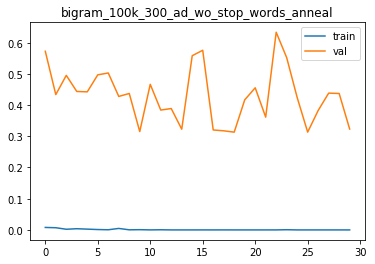

In [31]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_300_ad_wo_stop_words_anneal')
plt.show()

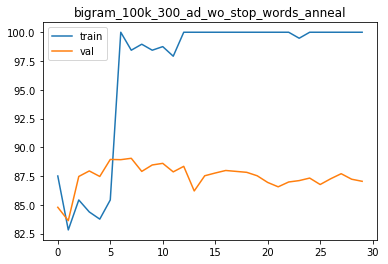

In [32]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_300_ad_wo_stop_words_anneal')
plt.show()

## Conclusion
Based on the experiment results, the best validation accuracy was obtained for constant learning rate

# 7. (Not listed Hyper-parameter) Max Sentence length
For the best tokenizer, n-gram, vocab size, Embedding dim, optimizer and learning rate schedule obtained from above, we will experiment with max sentence lenght: [100,200,300,400].

Other hyper-parameters are kept constant: tokenizer = w/o stop words, Max_sentence_length = 300,n-gram = upto 2, max_vocab_size = 100k, emb_dim = 300, Optimizer = Adam, lr = 1e-3 (constant).

## MAX_SENTENCE_LENGTH = 100

In [14]:
val_data_tokens = unpickling('val_data_tokens_wo_stop_words_n=2.p')
test_data_tokens = unpickling('test_data_wo_stop_tokens_n=2.p')
train_data_tokens = unpickling('train_data_wo_stop_tokens_n=2.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=2.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [35]:
model, loss_dict, acc_dict, incorrect_dict = train_model(100000,300,'Adam','bigram_100k_300_ad_wo_stop_words_const_ms = 100'\
                                                         , num_epochs = 5, MAX_SENTENCE_LENGTH = 100)

Epoch: [1/5], Step: [101/625], Validation Acc: 78.44


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/625], Validation Acc: 82.98
Epoch: [1/5], Step: [301/625], Validation Acc: 85.18
Epoch: [1/5], Step: [401/625], Validation Acc: 85.76
Epoch: [1/5], Step: [501/625], Validation Acc: 85.7
Epoch: [1/5], Step: [601/625], Validation Acc: 86.3
Epoch: [2/5], Step: [101/625], Validation Acc: 86.12
Epoch: [2/5], Step: [201/625], Validation Acc: 85.56
Epoch: [2/5], Step: [301/625], Validation Acc: 85.56
Epoch: [2/5], Step: [401/625], Validation Acc: 85.38
Epoch: [2/5], Step: [501/625], Validation Acc: 84.64
Epoch: [2/5], Step: [601/625], Validation Acc: 84.94
Epoch: [3/5], Step: [101/625], Validation Acc: 84.58
Epoch: [3/5], Step: [201/625], Validation Acc: 84.28
Epoch: [3/5], Step: [301/625], Validation Acc: 84.92
Epoch: [3/5], Step: [401/625], Validation Acc: 83.78
Epoch: [3/5], Step: [501/625], Validation Acc: 84.14
Epoch: [3/5], Step: [601/625], Validation Acc: 83.72
Epoch: [4/5], Step: [101/625], Validation Acc: 84.64
Epoch: [4/5], Step: [201/625], Validation Acc: 8

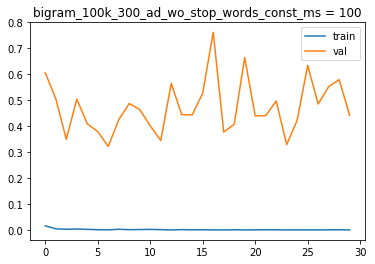

In [36]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_300_ad_wo_stop_words_const_ms = 100')
plt.show()

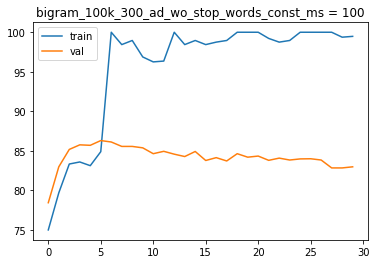

In [37]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_300_ad_wo_stop_words_const_ms = 100')
plt.show()

## MAX_SENTENCE_LENGTH = 200

In [38]:
val_data_tokens = unpickling('val_data_tokens_wo_stop_words_n=2.p')
test_data_tokens = unpickling('test_data_wo_stop_tokens_n=2.p')
train_data_tokens = unpickling('train_data_wo_stop_tokens_n=2.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=2.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [39]:
def imdb_collate_func(batch, MAX_SENTENCE_LENGTH = 200):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    rating_list = []
    names_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
        rating_list.append(datum[-2])
        names_list.append(datum[-1])
        
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)).type(torch.LongTensor), torch.LongTensor(length_list), \
            torch.LongTensor(label_list),torch.FloatTensor(rating_list), np.array(names_list)]

In [40]:
model, loss_dict, acc_dict, incorrect_dict = train_model(100000,300,'Adam','bigram_100k_300_ad_wo_stop_words_const_ms = 200'\
                                                         , num_epochs = 5, MAX_SENTENCE_LENGTH = 200)

Epoch: [1/5], Step: [101/625], Validation Acc: 81.82


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/625], Validation Acc: 86.16
Epoch: [1/5], Step: [301/625], Validation Acc: 87.48
Epoch: [1/5], Step: [401/625], Validation Acc: 87.38
Epoch: [1/5], Step: [501/625], Validation Acc: 87.86
Epoch: [1/5], Step: [601/625], Validation Acc: 88.54
Epoch: [2/5], Step: [101/625], Validation Acc: 88.44
Epoch: [2/5], Step: [201/625], Validation Acc: 88.64
Epoch: [2/5], Step: [301/625], Validation Acc: 88.02
Epoch: [2/5], Step: [401/625], Validation Acc: 88.04
Epoch: [2/5], Step: [501/625], Validation Acc: 87.36
Epoch: [2/5], Step: [601/625], Validation Acc: 87.04
Epoch: [3/5], Step: [101/625], Validation Acc: 87.66
Epoch: [3/5], Step: [201/625], Validation Acc: 87.56
Epoch: [3/5], Step: [301/625], Validation Acc: 87.78
Epoch: [3/5], Step: [401/625], Validation Acc: 87.12
Epoch: [3/5], Step: [501/625], Validation Acc: 87.22
Epoch: [3/5], Step: [601/625], Validation Acc: 87.56
Epoch: [4/5], Step: [101/625], Validation Acc: 87.4
Epoch: [4/5], Step: [201/625], Validation Acc: 

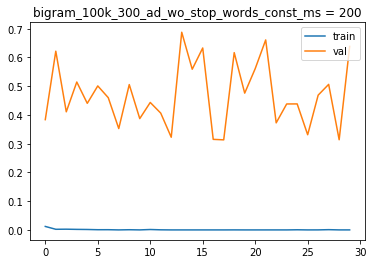

In [41]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_300_ad_wo_stop_words_const_ms = 200')
plt.show()

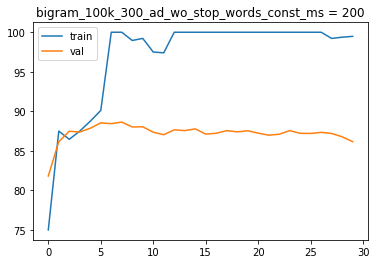

In [42]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_300_ad_wo_stop_words_const_ms = 200')
plt.show()

## MAX_SENTENCE_LENGTH = 300

In [43]:
val_data_tokens = unpickling('val_data_tokens_wo_stop_words_n=2.p')
test_data_tokens = unpickling('test_data_wo_stop_tokens_n=2.p')
train_data_tokens = unpickling('train_data_wo_stop_tokens_n=2.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=2.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [44]:
def imdb_collate_func(batch, MAX_SENTENCE_LENGTH = 300):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    rating_list = []
    names_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
        rating_list.append(datum[-2])
        names_list.append(datum[-1])
        
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)).type(torch.LongTensor), torch.LongTensor(length_list), \
            torch.LongTensor(label_list),torch.FloatTensor(rating_list), np.array(names_list)]

In [45]:
model, loss_dict, acc_dict, incorrect_dict = train_model(100000,300,'Adam','bigram_100k_300_ad_wo_stop_words_const_ms = 300'\
                                                         , num_epochs = 5, MAX_SENTENCE_LENGTH = 300)

Epoch: [1/5], Step: [101/625], Validation Acc: 84.2


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/625], Validation Acc: 84.72
Epoch: [1/5], Step: [301/625], Validation Acc: 88.02
Epoch: [1/5], Step: [401/625], Validation Acc: 88.22
Epoch: [1/5], Step: [501/625], Validation Acc: 88.26
Epoch: [1/5], Step: [601/625], Validation Acc: 89.8
Epoch: [2/5], Step: [101/625], Validation Acc: 89.66
Epoch: [2/5], Step: [201/625], Validation Acc: 88.66
Epoch: [2/5], Step: [301/625], Validation Acc: 89.08
Epoch: [2/5], Step: [401/625], Validation Acc: 88.78
Epoch: [2/5], Step: [501/625], Validation Acc: 88.4
Epoch: [2/5], Step: [601/625], Validation Acc: 88.14
Epoch: [3/5], Step: [101/625], Validation Acc: 88.28
Epoch: [3/5], Step: [201/625], Validation Acc: 88.14
Epoch: [3/5], Step: [301/625], Validation Acc: 87.24
Epoch: [3/5], Step: [401/625], Validation Acc: 87.62
Epoch: [3/5], Step: [501/625], Validation Acc: 87.38
Epoch: [3/5], Step: [601/625], Validation Acc: 87.5
Epoch: [4/5], Step: [101/625], Validation Acc: 88.24
Epoch: [4/5], Step: [201/625], Validation Acc: 87

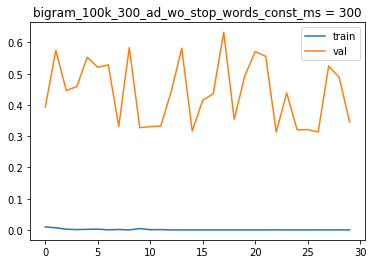

In [46]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_300_ad_wo_stop_words_const_ms = 300')
plt.show()

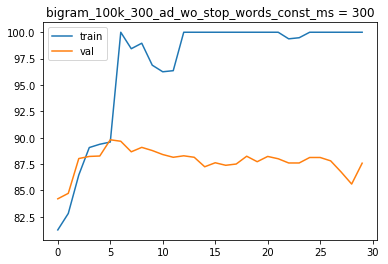

In [47]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_300_ad_wo_stop_words_const_ms = 300')
plt.show()

## MAX_SENTENCE_LENGTH = 400

In [48]:
val_data_tokens = unpickling('val_data_tokens_wo_stop_words_n=2.p')
test_data_tokens = unpickling('test_data_wo_stop_tokens_n=2.p')
train_data_tokens = unpickling('train_data_wo_stop_tokens_n=2.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=2.p')
[train_files,train_ratings, train_labels] = unpickling('req_train_files.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [49]:
def imdb_collate_func(batch, MAX_SENTENCE_LENGTH = 400):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    rating_list = []
    names_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
        rating_list.append(datum[-2])
        names_list.append(datum[-1])
        
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)).type(torch.LongTensor), torch.LongTensor(length_list), \
            torch.LongTensor(label_list),torch.FloatTensor(rating_list), np.array(names_list)]

In [50]:
model, loss_dict, acc_dict, incorrect_dict = train_model(100000,300,'Adam','bigram_100k_300_ad_wo_stop_words_const_ms = 400'\
                                                         , num_epochs = 5, MAX_SENTENCE_LENGTH = 400)

Epoch: [1/5], Step: [101/625], Validation Acc: 80.18


C:\Users\aakas\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BagOfWords. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/5], Step: [201/625], Validation Acc: 86.62
Epoch: [1/5], Step: [301/625], Validation Acc: 87.08
Epoch: [1/5], Step: [401/625], Validation Acc: 87.96
Epoch: [1/5], Step: [501/625], Validation Acc: 88.58
Epoch: [1/5], Step: [601/625], Validation Acc: 88.54
Epoch: [2/5], Step: [101/625], Validation Acc: 88.02
Epoch: [2/5], Step: [201/625], Validation Acc: 88.8
Epoch: [2/5], Step: [301/625], Validation Acc: 88.82
Epoch: [2/5], Step: [401/625], Validation Acc: 88.8
Epoch: [2/5], Step: [501/625], Validation Acc: 88.54
Epoch: [2/5], Step: [601/625], Validation Acc: 87.52
Epoch: [3/5], Step: [101/625], Validation Acc: 87.76
Epoch: [3/5], Step: [201/625], Validation Acc: 87.88
Epoch: [3/5], Step: [301/625], Validation Acc: 88.38
Epoch: [3/5], Step: [401/625], Validation Acc: 88.26
Epoch: [3/5], Step: [501/625], Validation Acc: 87.34
Epoch: [3/5], Step: [601/625], Validation Acc: 87.62
Epoch: [4/5], Step: [101/625], Validation Acc: 88.02
Epoch: [4/5], Step: [201/625], Validation Acc: 8

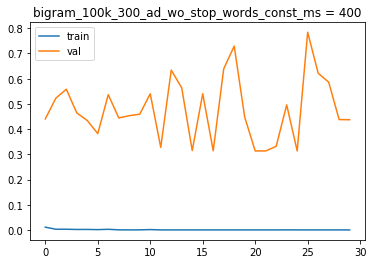

In [51]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_300_ad_wo_stop_words_const_ms = 400')
plt.show()

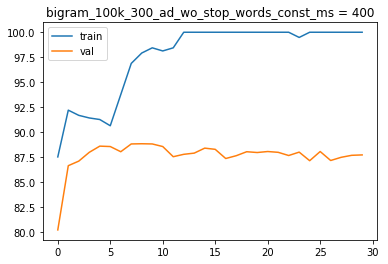

In [52]:
plt.plot(acc_dict['train'], label = 'train')
plt.plot(acc_dict['val'], label = 'val')
plt.legend()
plt.title('bigram_100k_300_ad_wo_stop_words_const_ms = 400')
plt.show()

## Conclusion
As seen from above experiments, the best validation accuracy was obtained for max_sentence_length = 300

# Final Best Hyper-parameters:
Best hyper-parameters are  tokenizer = w/o stop words, Max_sentence_length = 300,n-gram = upto 2, max_vocab_size = 100k, emb_dim = 300, Optimizer = Adam, lr = 1e-3 (constant) and Max_sentence_length = 300.

Error Analysis of the best model:
3 Correct and 3 incorrect predictions are:

In [66]:
best_model = torch.load('bigram_100k_300_ad_wo_stop_words_const_ms = 300')
best_model.eval()

BagOfWords(
  (embed): Embedding(100002, 300, padding_idx=0)
  (linear): Linear(in_features=300, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=2, bias=True)
)

In [67]:
val_data_tokens = unpickling('val_data_tokens_wo_stop_words_n=2.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=2.p')
[val_files,val_ratings, val_labels] = unpickling('req_val_files.p')

In [69]:
token2id, id2token = build_vocab(all_tokens,100000)
val_data_indices = token2index_dataset(val_data_tokens,token2id)
val_dataset = ImdbDataset(val_data_indices, val_labels, val_ratings, val_files,MAX_SENTENCE_LENGTH = 300)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=32,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)

In [70]:
criterion = nn.CrossEntropyLoss()

In [83]:
_,_,_,_,preds = test_model(val_loader,best_model,criterion)

In [87]:
pred = np.array(preds[0])

# 3 correct predictions

In [93]:
correct_pred = pred[:,:][:,pred[1,:] == pred[-1,:]]

In [97]:
for i in range(3):
    path, pred_value, true_value = correct_pred[:,i]
    sample = open(path,'r',encoding="utf8").read()
    print('Predicted Value = ',pred_value)
    print('True Value = ', true_value)
    print(sample)
    print('-'*50)

Predicted Value =  0
True Value =  0
I stole this movie when I was a freshmen in college. I've tried to watch it three times, the second two because friends wanted to see it. "Sweet, Adam Sandler, I've never heard of this movie, but since he's so funny its gotta be funny." Wrong! I can't make myself watch this pile of crap after the dream boxing match/insult war, where burning the guy with a good zinger causes your opponent physical pain. You would think that terrible comedy hurting you is ridiculous, but after watching this you'll know its true. This movie isn't worth the price I paid for it. I've watched a ton of Steven segal movies, and I've even watched Crossroads twice... but I still couldn't watch this.
--------------------------------------------------
Predicted Value =  0
True Value =  0
Oh a vaguely once famous actress in a film where she plays a mother to a child . It`s being shown on BBC 1 at half past midnight , I wonder if ... yup it`s a TVM <br /><br />You`ve got to hand 

# 3 incorrect predictions

In [99]:
incorrect_pred = pred[:,:][:,pred[1,:] != pred[-1,:]]
for i in range(3):
    path, pred_value, true_value = incorrect_pred[:,i]
    sample = open(path,'r',encoding="utf8").read()
    print('Predicted Value = ',pred_value)
    print('True Value = ', true_value)
    print(sample)
    print('-'*50)

Predicted Value =  1
True Value =  0
This movie is AWESOME. I watched it the other day with my cousin Jay-Jay. He said it was alright, but i think it RULEZZZ! I mean, it's so cool. Ted V. Mikels is so brave and smart. He made a movie totally unlike those terrible Hollywood films, like the Matrix and STop or my Mom will Shoot. It could have been better, though. I like ninjas and pirates. I also like that big talon that the funny man wears. I think he's the coolest guy since that Domino Pizza claymation guy. Not only does this movie look really cool, like those out-of-focus movies my dad made of my birthday when I turned 6. BUt it tells a complex tale with dozens of characters that seem to be totally unrelated, but they all meet up in the end. It's genius how this web is woven to make everything meet up. I wish Ted V. Mikels would make a sequel. But it needs more aliens. And a pirate.
--------------------------------------------------
Predicted Value =  1
True Value =  0
So so special ef

# Testing model on test set

In [53]:
best_model = torch.load('bigram_100k_300_ad_wo_stop_words_const_ms = 300')

In [56]:
test_data_tokens = unpickling('test_data_wo_stop_tokens_n=2.p')
all_tokens = unpickling('all_train_wo_stop_tokens_n=2.p')
[test_files,test_ratings, test_labels] = unpickling('req_test_files.p')

In [58]:
token2id, id2token = build_vocab(all_tokens,100000)
test_data_indices = token2index_dataset(test_data_tokens,token2id)
test_dataset = ImdbDataset(test_data_indices, test_labels, test_ratings, test_files,MAX_SENTENCE_LENGTH = 300)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=32,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)
criterion = nn.CrossEntropyLoss()

In [60]:
test_acc, test_loss, test_incorrect_fp, test_incorrect_fn = test_model(test_loader,best_model,criterion)

In [61]:
print('Test Accuracy for the best model config = ', test_acc)

Test Accuracy for the best model config =  88.24
